# Milestone 3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

We start by loading the tables.

In [2]:
df_plot = pd.read_csv("data/MovieSummaries/plot_summaries.txt", sep='\t', header=None, names=["wikiID", "plot"])

df_meta = pd.read_csv("data/MovieSummaries/movie.metadata.tsv", sep='\t', header=None, 
    names=["wikiID", "freeID", "name", "release_date", "revenue", "runtime", "languages", "countries", "genres"])

df_char = pd.read_csv("data/MovieSummaries/character.metadata.tsv", sep='\t',header=None, 
    names=["WikiID", "freeID", "release_date", "char_name", "actor_DOB", "actor_gender", "actor_height", "actor_ethnicity",
           "actor_name", "Actor_age", "freeID_char_map", "FreeID_char", "FreeID_actor"])

df_char_names = pd.read_csv('data/MovieSummaries/name.clusters.txt', sep="\t", header=None, 
    names=["char_name", "freeID_char_map"])

df_tropes = pd.read_csv('data/MovieSummaries/tvtropes.clusters.txt', sep='\t', header=None, names=["trope", "details"])

## Data features and missing values

In [3]:
df_plot.head()

,wikiID,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [4]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wikiID  42303 non-null  int64 
 1   plot    42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


In [5]:
df_meta.head()

,wikiID,freeID,name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [6]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wikiID        81741 non-null  int64  
 1   freeID        81741 non-null  object 
 2   name          81741 non-null  object 
 3   release_date  74839 non-null  object 
 4   revenue       8401 non-null   float64
 5   runtime       61291 non-null  float64
 6   languages     81741 non-null  object 
 7   countries     81741 non-null  object 
 8   genres        81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


Looking at the output above, we might think that the languages, countries and genres columns have no missing elements but actually some elements are just empty dictionary values

In [7]:
print(df_meta['languages'].value_counts()['{}'])
print(df_meta['countries'].value_counts()['{}'])
print(df_meta['genres'].value_counts()['{}'])

13866
8154
2294


Also, if we want to make use of the release date we can already convert it to datetime and check if we have more missing values.

In [8]:
df_meta['release_date'] = pd.to_datetime(df_meta['release_date'], errors = 'coerce')
print(df_meta['release_date'].shape[0] - df_meta['release_date'].isnull().sum())

74838


In [9]:
df_char.head()

,WikiID,freeID,release_date,char_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,Actor_age,freeID_char_map,FreeID_char,FreeID_actor
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [10]:
df_char.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   WikiID           450669 non-null  int64  
 1   freeID           450669 non-null  object 
 2   release_date     440674 non-null  object 
 3   char_name        192794 non-null  object 
 4   actor_DOB        344524 non-null  object 
 5   actor_gender     405060 non-null  object 
 6   actor_height     154824 non-null  float64
 7   actor_ethnicity  106058 non-null  object 
 8   actor_name       449441 non-null  object 
 9   Actor_age        292556 non-null  float64
 10  freeID_char_map  450669 non-null  object 
 11  FreeID_char      192804 non-null  object 
 12  FreeID_actor     449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


In [11]:
df_char_names.head()

,char_name,freeID_char_map
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [12]:
df_char_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   char_name        2666 non-null   object
 1   freeID_char_map  2666 non-null   object
dtypes: object(2)
memory usage: 41.8+ KB


In [13]:
df_tropes.head()

,trope,details
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


In [14]:
df_tropes = df_tropes.drop(["details"], axis=1).join(pd.json_normalize(df_tropes["details"].map(json.loads).tolist())).rename(
    columns={"id":"freeID_char_map"})

df_tropes.head()

,trope,char,movie,freeID_char_map,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [15]:
df_tropes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   trope            501 non-null    object
 1   char             501 non-null    object
 2   movie            501 non-null    object
 3   freeID_char_map  501 non-null    object
 4   actor            501 non-null    object
dtypes: object(5)
memory usage: 19.7+ KB


---
## Exploratory data analysis

### Genres, languages and countries

We want to identify the most represented genres, languages and countries.

In [16]:
def fcount(df):
    df2 = pd.DataFrame(data={
        'id': df.apply(lambda x: list(json.loads(x).keys())),
        'name': df.apply(lambda x: list(json.loads(x).values()))
    })
    
    distinctf = []
    counter = []

    for i in range(df2.shape[0]):
        fid = df2["id"].iloc[i]
        fname = df2["name"].iloc[i]
        for j in range(len(fid)):
            if [fid[j], fname[j]] not in distinctf:
                distinctf.append([fid[j], fname[j]])
                counter.append(1)
            else:
                counter[distinctf.index([fid[j], fname[j]])] += 1

    new = pd.DataFrame(data={
        'id': [s[0] for s in distinctf],
        'name': [s[1] for s in distinctf],
        'count': counter
    })
    
    return new.sort_values(by="count", ascending=False, ignore_index=True)

In [17]:
df_genre = fcount(df_meta["genres"])
df_genre.head(20)

,id,name,count
0,/m/07s9rl0,Drama,34007
1,/m/01z4y,Comedy,16349
2,/m/02l7c8,Romance Film,10234
3,/m/01g6gs,Black-and-white,9094
4,/m/02kdv5l,Action,8798
5,/m/01jfsb,Thriller,8744
6,/m/02hmvc,Short Film,8141
7,/m/03q4nz,World cinema,7155
8,/m/0lsxr,Crime Fiction,6948
9,/m/0219x_,Indie,6897


In [18]:
df_lang = fcount(df_meta["languages"])
df_lang.head(20)

,id,name,count
0,/m/02h40lc,English Language,40891
1,/m/03k50,Hindi Language,3744
2,/m/06nm1,Spanish Language,3673
3,/m/064_8sq,French Language,3422
4,/m/06ppq,Silent film,3183
5,/m/02bjrlw,Italian Language,2531
6,/m/03_9r,Japanese Language,2295
7,/m/04306rv,German Language,2258
8,/m/07c9s,Tamil Language,1896
9,/m/0999q,Malayalam Language,1448


In [19]:
df_country = fcount(df_meta["countries"])
df_country.head(20)

,id,name,count
0,/m/09c7w0,United States of America,34408
1,/m/03rk0,India,8411
2,/m/07ssc,United Kingdom,7868
3,/m/0f8l9c,France,4395
4,/m/03rjj,Italy,3163
5,/m/03_3d,Japan,2647
6,/m/0d060g,Canada,2534
7,/m/0345h,Germany,2393
8,/m/0jgd,Argentina,1468
9,/m/03h64,Hong Kong,1240


There might be a correlation between the country and language features.

### Release date distribution

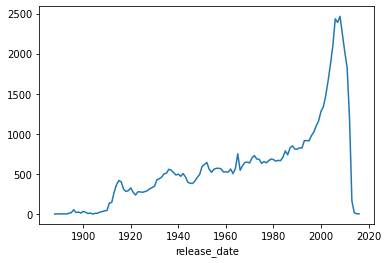

In [20]:
df_meta.groupby(df_meta["release_date"].dt.year).count()['wikiID'].plot()
plt.show()

We want to study the similarity between two movies so the date of their releases can be interesting. In this case, the exact release date might not be necessary, because it is expected that the difference would lie between movies that have for example 10 years of difference not just a few months. Actually, in some cases we only have the year of the release, so it might be simpler to only store the year of the release for all movies in order to keep homogeneous data.

### Runtime distribution

In [21]:
print(df_meta['runtime'].max())

1079281.0


2 years of runtime?

In [22]:
print(df_meta[df_meta['runtime'] >= 400].shape[0])
print(df_meta[df_meta['runtime'] <= 3].shape[0])

66
250


More than 6 hours of runtime seems too large and less than 3 minutes seems too short.

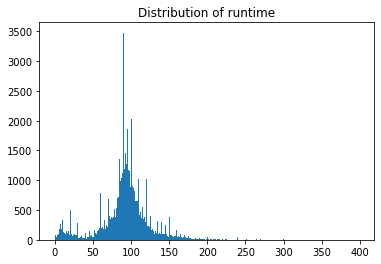

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_meta[df_meta['runtime'] < 400]['runtime'], bins=400)
ax.set_title('Distribution of runtime')

plt.show()

We can observe that the distribution is more concentrated around a runtime of 90 minutes but it appears there is a cluster around 20 which might corresponds to short films (6th most represented movie genre in the dataset).

The exact value of the runtime does not always seem to be reliable data, and looking at the distribution it might be a good idea to replace the runtime by an attribute like "short", "long" or "don't know" (if runtime is NaN).

### Runtime distribution

<AxesSubplot: >

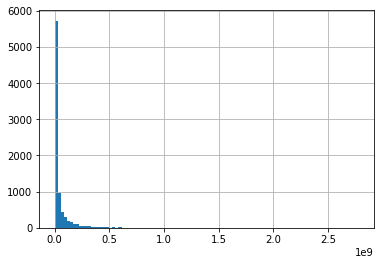

In [24]:
df_meta['revenue'].dropna().hist(bins=100)

In [25]:
print(df_meta['revenue'].max())

2782275172.0


In [26]:
print(df_meta[df_meta['revenue']==df_meta['revenue'].max()].name)

23702    Avatar
Name: name, dtype: object


There is a very large different between most of the movies and the movies that had a huge success such as "Avatar".

Note that the box office revenue is absent for most of the movies and we might not need it to compute the similarity between two movies. Therefore, we estimated that this feature would not be useful for our project.

### Distribution of the number of words per plot

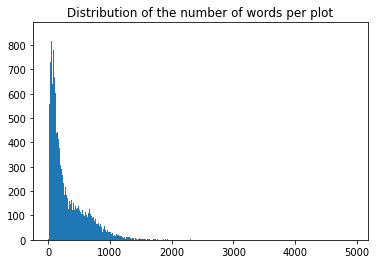

In [27]:
#use raw plot_summaries and count nb of words in each plot 
df_plot_fltr = df_plot.copy()
df_plot_fltr['nb_words'] = df_plot_fltr['plot'].apply(lambda n: len(n.split()))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_plot_fltr['nb_words'], bins=1000)
ax.set_title('Distribution of the number of words per plot')

plt.show()

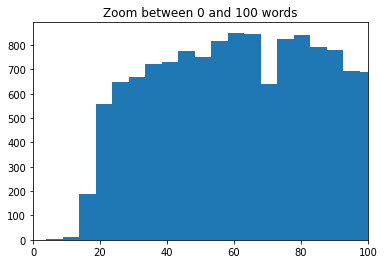

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_plot_fltr['nb_words'], bins=1000)
ax.set_title('Zoom between 0 and 100 words')
plt.xlim([0, 100])

plt.show()

We still find some extreme values in the distribution. In particular, some plots have less than 20 words, on the other hand there are plots with thousands of words.

In the preprocessing, we decided to discard the movies with plots that are less than 10 words as they might not be relevant when we will apply topic extraction.

### Distribution of the number of characters per movie

First we will group all the characters by movie. So if a movie has at least one labeled character, we will be able to count its number of character so that we can have an insight on the distribution of the number of characters for a movie.

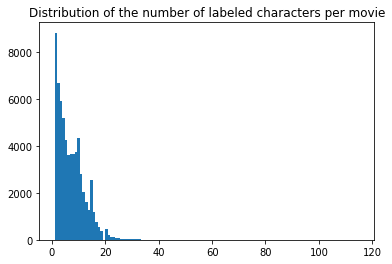

In [29]:
df_char_fltr = df_char[['freeID','FreeID_actor']].copy()
df_char_fltr = df_char_fltr.groupby(['freeID']).size()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_char_fltr, bins=120)
ax.set_title('Distribution of the number of labeled characters per movie')

plt.show()

In [30]:
print("Number of movies without any labeled character: ", 
      df_meta.shape[0] - df_meta[df_meta['freeID'].isin(df_char_fltr.index)].shape[0])

Number of movies without any labeled character:  17411


This can be missing information but it is also logical that some movies such as documentaries do not have any character.

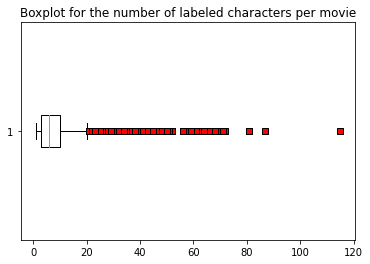

In [31]:
red_square = dict(markerfacecolor='r', marker='s')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(df_char_fltr, vert=False, flierprops=red_square)
ax.set_title('Boxplot for the number of labeled characters per movie')
plt.show()

In [32]:
print("1rst quartile, median and 3rd quartile values: ")
print(df_char_fltr.quantile([0.25,0.5,0.75]))

1rst quartile, median and 3rd quartile values: 
0.25     3.0
0.50     6.0
0.75    10.0
dtype: float64


## Join the dataframes

The feature connecting dataframes together is the Wikipedia ID. Also there are more metadatas of movies (81741 movies) than plots (42303 movies). We will only keep the metadatas of the movies we know the plot of.

In [33]:
dfull = df_meta.merge(df_plot, how='inner', on="wikiID")
dfull.head()

,wikiID,freeID,name,release_date,revenue,runtime,languages,countries,genres,plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a..."


Only a small fraction of the characters have been labellised with a trope (500), compared to the number of unlabeled (450669). Here is the dataframe containing the characters with trope

In [34]:
df_char_trope = df_char.merge(df_tropes, how='inner', on='freeID_char_map')

df_char_trope.drop(columns=["char", "actor"], inplace=True)
df_char_trope.head()

,WikiID,freeID,release_date,char_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,Actor_age,freeID_char_map,FreeID_char,FreeID_actor,trope,movie
0,196176,/m/01bwgr,1971-11-03,David Sumner,1937-08-08,M,1.66,/m/041rx,Dustin Hoffman,34.0,/m/0k3v65,/m/0ch916z,/m/0bl2g,tranquil_fury,Straw Dogs
1,1157158,/m/04c13q,2002-03-29,Sheldon Mopes,1969-08-18,M,1.83,NaN,Edward Norton,32.0,/m/0jx3b8,/m/0gy99_8,/m/01515w,granola_person,Death to Smoochy
2,504242,/m/02j9_2,2005-08-22,Mr. Universe,1978-05-15,M,1.68,/m/041rx,David Krumholtz,27.0,/m/0k31lb,/m/02sgjdt,/m/05cx7x,playful_hacker,Serenity
3,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,charmer,The Music Man
4,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,loveable_rogue,The Music Man


In [35]:
df_char.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   WikiID           450669 non-null  int64  
 1   freeID           450669 non-null  object 
 2   release_date     440674 non-null  object 
 3   char_name        192794 non-null  object 
 4   actor_DOB        344524 non-null  object 
 5   actor_gender     405060 non-null  object 
 6   actor_height     154824 non-null  float64
 7   actor_ethnicity  106058 non-null  object 
 8   actor_name       449441 non-null  object 
 9   Actor_age        292556 non-null  float64
 10  freeID_char_map  450669 non-null  object 
 11  FreeID_char      192804 non-null  object 
 12  FreeID_actor     449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


In [36]:
df_char_list = df_char[['freeID','char_name']].groupby('freeID')['char_name'].apply(list).reset_index(name='characters')
df_char_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64330 entries, 0 to 64329
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   freeID      64330 non-null  object
 1   characters  64330 non-null  object
dtypes: object(2)
memory usage: 1005.3+ KB


In [37]:
df_actor_list = df_char[['freeID','actor_name']].groupby('freeID')['actor_name'].apply(list).reset_index(name='actors')
df_actor_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64330 entries, 0 to 64329
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   freeID  64330 non-null  object
 1   actors  64330 non-null  object
dtypes: object(2)
memory usage: 1005.3+ KB


---
## Preprocessing

We decided to filter our data, and remove the elements without a genre or with less than 10 words in their plot, because these are the features that we think are the most important in the idea of our project.

In [38]:
df_clean = (dfull[(dfull['genres'] != '{}') & (dfull['plot'].apply(lambda s: len(s.split())) > 10)]).drop(
    columns=['revenue'])

print('number of movies remaining after movie metadata preprocessing: ', df_clean.shape[0])

number of movies remaining after movie metadata preprocessing:  41783


We are formatting the data to facilitate the analysis.

In [39]:
df_clean['countries'] = pd.DataFrame(data={'countries': df_clean['countries'].apply(lambda x: set(json.loads(x).values()))})
df_clean['languages'] = pd.DataFrame(data={'languages': df_clean['languages'].apply(lambda x: set(json.loads(x).values()))})
df_clean['genres'] = pd.DataFrame(data={'genres': df_clean['genres'].apply(lambda x: set(json.loads(x).values()))}) 

We decided to replace the full release date by the year of release, so that all the movies have only an integer for this feature, and because we estimated that the year was sufficient to establish a similarity on the release date. 

In [40]:
df_clean['release_date'] = df_clean['release_date'].dt.year.apply(lambda x: int(x) if x == x else None)

We decided to redefine the runtime either as "short" for movies with a runtime less than 40 minutes (a short film is generally less than 40 minutes), "long" for movies with a runtime larger than 40 minutes or "unknown" if we do not know the runtime.

In [41]:
df_clean['runtime'] = df_clean['runtime'].apply(lambda x: 'short' if x <= 40 else ('long' if x > 40 else None))

We add the actors list and character list to the df_clean dataframe

In [42]:
df_clean = df_clean.merge(df_char_list, how='inner', on='freeID')
df_clean = df_clean.merge(df_actor_list, how='inner', on='freeID')

In [43]:
df_clean['actors'] =pd.DataFrame(data={'actors': df_clean['actors'].apply(lambda x: list(x))})
df_clean['actors'] =pd.DataFrame(data={'actors': df_clean['actors'].apply(lambda x: [item for item in x if not(pd.isna(item)) == True] )})
df_clean['actors'] =pd.DataFrame(data={'actors': df_clean['actors'].apply(lambda x: set(x) )})
df_clean['characters'] =pd.DataFrame(data={'characters': df_clean['characters'].apply(lambda x: list(x))})
df_clean['characters'] =pd.DataFrame(data={'characters': df_clean['characters'].apply(lambda x: [item for item in x if not(pd.isna(item)) == True] )})
df_clean['characters'] =pd.DataFrame(data={'characters': df_clean['characters'].apply(lambda x: set(x))})

In [44]:
df_clean.head(5)

,wikiID,freeID,name,release_date,runtime,languages,countries,genres,plot,characters,actors
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,long,{English Language},{United States of America},"{Science Fiction, Horror, Space western, Thril...","Set in the second half of the 22nd century, th...","{Zimmerman, Whitlock, Michael Descanso, Dos, M...","{Peter Jason, Jason Statham, Pam Grier, Robert..."
1,9363483,/m/0285_cd,White Of The Eye,1987.0,long,{English Language},{United Kingdom},"{Erotic thriller, Psychological thriller, Thri...",A series of murders of rich young women throug...,{},"{David Keith, Cathy Moriarty}"
2,261236,/m/01mrr1,A Woman in Flames,1983.0,long,{German Language},{Germany},{Drama},"Eva, an upper class housewife, becomes frustra...",{},"{Hanns Zischler, Gudrun Landgrebe, Mathieu Car..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002.0,long,{English Language},{South Africa},"{Adventure, World cinema, Fantasy, Family Film}","Every hundred years, the evil Morgana returns...",{Morgana},"{Byron Taylor, Dale Cutts, Gideon Emery, Kelly..."
4,6631279,/m/0gffwj,Little city,1997.0,long,{English Language},{United States of America},"{Comedy-drama, Romance Film, Romantic drama, E...","Adam, a San Francisco-based artist who works a...","{Nina, Rebecca}","{Joanna Going, JoBeth Williams, Penelope Ann M..."


---
## Scraping

Scraping is done in the separate file `Scraping.ipynb` only once. Here we import the resulted file `scrapped_tot.csv` to merge with our `df_clean`. We scrap:
* for the director, as we believe that a director will be more prone to make movies with similar styles
* for the color (to know if a movie is in color or black and white). Even though this is mostly correlated with the release date, during the transition period (around the 1950s) it gives an additional information.

In [45]:
df_scrapped = pd.read_csv('./scrapped/scrapped.csv')
df_scrapped.drop(columns = df_scrapped.columns[0], axis = 1, inplace= True)
df_clean = df_clean.merge(df_scrapped,on='freeID',how='left')
print(df_clean.shape)

df_clean.to_csv('df_clean.csv', encoding='utf-8')


(37476, 13)


In [46]:
df_clean.head(3)

,wikiID,freeID,name,release_date,runtime,languages,countries,genres,plot,characters,actors,director,color
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,long,{English Language},{United States of America},"{Science Fiction, Horror, Space western, Thril...","Set in the second half of the 22nd century, th...","{Zimmerman, Whitlock, Michael Descanso, Dos, M...","{Peter Jason, Jason Statham, Pam Grier, Robert...",John Carpenter,color
1,9363483,/m/0285_cd,White Of The Eye,1987.0,long,{English Language},{United Kingdom},"{Erotic thriller, Psychological thriller, Thri...",A series of murders of rich young women throug...,{},"{David Keith, Cathy Moriarty}",Cassian Elwes,color
2,261236,/m/01mrr1,A Woman in Flames,1983.0,long,{German Language},{Germany},{Drama},"Eva, an upper class housewife, becomes frustra...",{},"{Hanns Zischler, Gudrun Landgrebe, Mathieu Car...",Robert van Ackeren,color


We check how many we managed to scrap successfully:

In [47]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37476 entries, 0 to 37475
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wikiID        37476 non-null  int64  
 1   freeID        37476 non-null  object 
 2   name          37476 non-null  object 
 3   release_date  35762 non-null  float64
 4   runtime       32453 non-null  object 
 5   languages     37476 non-null  object 
 6   countries     37476 non-null  object 
 7   genres        37476 non-null  object 
 8   plot          37476 non-null  object 
 9   characters    37476 non-null  object 
 10  actors        37476 non-null  object 
 11  director      19094 non-null  object 
 12  color         15138 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 4.0+ MB


Which means we have the information for about half the movies. It's not perfect, but we will still be able to use this additional information to bring closer some movies.

# Graph construction

To construct the graph we define a similarity for each feature, and compute a matrix for this similarity. For the total similarity we will take the weighted sum of these matrices. Each matrix is quite big (2.8GB), but it's not absurdly big, so we can affort to store it.

---
## Choice of attributes based on data exploratory analysis

We try to have a maximum of useful attributes to estimate the similarity between the films of the dataset, and to keep as much movies as possible to maximize the chance of being able to recommand similar movies.

When we "filter" an attribute, we remove all instances that are missing that attribute's information.

We believe that the mandatory attribute conditions to be retained in our final dataset are:
* A present title: without a film name, there is no film (hard to name it, to advise it)
* At least one genre labeled (probably one of the most significant attributes for similarity)
* A plot of at least 10 existing words (impose a minimum size so that the subsequent analysis of the topics is accurate)

We eliminate the 'revenue' attribute, due to the small number of movies described by this attribute.

The attributes that are not filtered, but kept to help with the information they carry are:
* Runtime
* Release date
* Language: will be ignored if not provided
* Country: will be ignored if not provided
* Characters: Will be ignored if not provided.

By exploring the wikidata pages by scraping, we recover the name of the producer and the information on the color of the film. These two attributes
were the most constantly present among other more scattered ones (filming location, cinematographer, composer, etc.). We therefore create an additional dataset thanks to the code present in the "scraping" section above.

We discretize the `date_release` in years of publication. The runtime is transformed into short/long categories.

Among the attributes selected for further analysis, we can create attributes resulting from a multiplication between two attributes, such as color and release date.

We have these attributes, with their possible values if categorized in `df_clean`:
- `Plot`
- `Title`
- `Release_date`
- `Genres`: genres list
- `Countries`: countries list
- `Language`: languages list
- `Runtime`: `short`, `long` or `don't know`
- `Director`: Director name or `None`
- `Color`: colored, black and white or `None`

In `df_clean_char`, we holded only the actors names and character names.

---
## Methods to study similarities accross chosen attributes

### 1. Computing the global similarity between movies taking into account all attributes


In the following parts, we will see methods to compute the respective similarity between movies based on each respective feature. We will want to merge all these similarities into one global similarity metric that will take into accounts all attributes.
We compute the total similarity between two films as followed:
$$
S_{tot}=\sum_{i}^{N} w_iS_i
$$
where $w_i$ is the weight associated to the similarity $S_i \in [0,1]$ of the attribute $i \in $ {plot, title, genre, runtime, release_year, country, language, actors, characters, director, color }.

### 2. Algorithm to study similarity between movies attributes

In this part we will propose several methods in order to assess the similarity between movies based on the attributes that we chose here-above. In the [Annexe: Mathematical definitions related to similarity](#Annexe:-Mathematical-definitions-related-to-similarity) we explain the mathematical details and definitions on which the following algorithms are based.

In [62]:
import math
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

#### Jaccard similarity implementation
**Method**
The jaccard similarity is more appropriate to compute similarities between datasets of categorical attributes where we want to see if these datasets have some attributes in common or not, and how many they are.

**Implementation**
`jaccard_similarity` function written here below. Since we compare to what extent different movies attributes contain the exact same words, we may need to add a lemmatizer for example to take care of same words being in the singular or plural form, or having uppercase or lowercase initial letter.

**Movie Attribute similarity that can be studied**
- Movie genre
- Movie Language 
- Movie Country
- Actors
- Characters
- Director

Here we can use this method for these attributes because we want to find which of those attributes contain the exact same words and study the similarity based on this analysis. 

In [51]:
def jaccard_similarity(x,y):
  """ returns the jaccard similarity between two sets x and y"""
  intersection_cardinality = len(set.intersection(*[x, y]))
  union_cardinality = len(set.union(*[x,y]))
  if union_cardinality == 0:
    return 0.0
  else:
    return intersection_cardinality/float(union_cardinality)

genre_list = []
genre_list.append(['Drama', 'Mystery', 'Fantasy', 'Adventure'])
genre_list.append(['Fantasy Adventure', 'Adventure', 'Epic', 'Fantasy', 'Drama', 'Action', 'Sword and sorcery films'])
genre_list.append(['Satire', 'Comedy', 'Family film'])
genre_list.append(['Musical', 'Drama', 'Comedy'])
genre_list.append(['Action'])
genre_list.append([])
genre_list.append([])

print("Example of similarities computed with jaccard similarity for the attribute -Movie genre- :")
print("Between lists 0 and 1:",jaccard_similarity(set(genre_list[0]), set(genre_list[1])))
print("Between lists 2 and 3:",jaccard_similarity(set(genre_list[2]), set(genre_list[3])))
print("Between lists 1 and 7:",jaccard_similarity(set(genre_list[1]), set(genre_list[4])))
print("Between lists 6 and 8:",jaccard_similarity(set(genre_list[5]), set(genre_list[6])))


Example of similarities computed with jaccard similarity for the attribute -Movie genre- :
Between lists 0 and 1: 0.375
Between lists 2 and 3: 0.2
Between lists 1 and 7: 0.14285714285714285
Between lists 6 and 8: 0.0


#### Similarity between binary attributes
**Method**

We have a unique discrete attribute that can take the values: $\left\{1, 0, \text{Nan} \right\}$, where NaN is the case where we don't have information about this attribute.  

**Implementation**

The similarity here is simply 1 if both attributes are equal to 1 or both equal to 0. If at least one of the two attributes is Nan then the similarity is 0.

**Movie Attribute similarity that can be studied**

- Color (1: Movie in colours, 0: Movie in black and white, NaN)
- Runtime (1: full-length film, 0: short film, NaN)

In [52]:
def isNaN(string):
    return string != string

def binary_similarity(x,y):
    '''
    returns the similarity in values of 
    0 or 1
    '''
    if(isNaN(x) | isNaN(y)):
        return 0
    if(x==y):
        return 1
    else:
        return 0   

#### Similarity between positive integers attributes
**Method**
We want compute the similiarity between two one-dimension continuous variables that belong to $\mathbb{N}$. 

**Implementation**
We start by computing the distance between the two positive integer by computing the manhattan distance: 
$$
d(A,B)=|A-B|
$$
We want to normalize this distance so that $d \in [0,1]$. We do a Min-Max normalization that performs a linear transformation on the original data. This technique gets all the scaled data in the range $[0,1]$. This allows to preserve the relationships among the original data values. The formula to achieve this is the following:
$$
d_{scaled}=\frac{d-d_{min}}{d_{max}-d_{min}}
$$
The cost of having this bounded range is that we will end up with smaller standard deviations, which can suppress the effect of outliers.
We can finally compute the similarity based on this distance:
$$
S=1-d_{scaled}
$$
where $S \in [0,1]$.

**Movie Attribute similarity that can be studied**
- Release year

In [53]:
def integer_similarity(distance_matrix):
    '''
    inputs: matrice of distances
    output: similarity associated to normalized distance
    '''

    integ_similiarity=np.zeros(distance_matrix.shape)
    
    idx=np.where(~np.isnan(distance_matrix))
    idx2=np.where(np.isnan(distance_matrix))

    d_max = np.max(distance_matrix[idx])
    d_min = np.min(distance_matrix[idx])
    
    integ_similiarity[idx]=np.ones(distance_matrix[idx].shape) - (distance_matrix[idx]-d_min)/(d_max-d_min)    
    integ_similiarity[idx2]=0
    
    return integ_similiarity

#### tf-idf : Term frequency-inverse document frequency
**Term frequency and Inverse document frequency**

$$
tf(t,d)=\frac{f_{t,d}}{ \sum_{t' \in d} f_{t',d} } \quad \textrm{and} \quad idf(t,D)=log(\frac{N}{|d\in D:t\in d|})
$$
where $f_{t,d}$ = raw frequency = number of times a term $t$ occurs in document $d$, $ \sum_{t' \in d} f_{t',d}$=total number of terms $t'$ in $d$ by suming each independent occurrence
<br>
where $N$=$|D|$= number of documents in corpus $D$, $|d\in D:t\in d|$= number of documents where t appears (where $tf(t,d)\neq 0$)

To prevent bias towards longer documents, the term frequency can be computed as follow:
$$
tf(t,d)=0.5+0.5\frac{f_{t,d}}{max(f_{t',d}:t'\in d)}
$$
To avoid divinding by zero, the idf denominator can ba adjusted as follow:
$$
idf(t,D)=log(\frac{N}{1+|d\in D:t\in d|})
$$
**Term frequency-inverse document frequency**

From the term frequency and the inverse document frequency we can compute the tf-idf:
$$
tf-idf(t,D)=tf(t,d) \cdot idf(t,D)
$$

The tf-idf reflects how important a word is to a document in corpus. tf-idf increase proportionally with the number of times a word appear in a document, but it is offset by the number of documents in the corpus that contains the word. It is high when there is high term frequency in document d **and** low document frequency of the term in the whole corpus. This helps to adjust the fact that some words appear more frequently that we can define as common terms. It tends to filter out those common words.

**Implementation**

tfidf can be implemented using the `sklearn` or `GenSim` opensource library. After obtaining tf-idf associated for each word in each text, we can associate to each text a vector composed of his words tf-idf and null values for other words.
Then we can compute the **cosine similarity** between those texts represented as vectors.

**Movie Attribute similarity that can be studied**
- Title

In [54]:
def dot(A,B): 
  return (sum(a*b for a,b in zip(A,B)))

def cosine_similarity_simple(a,b):
  """ returns cosine similarity between two lists """
  return dot(a,b)/((dot(a,a)**.5)*(dot(b,b)**.5)) 

print("Example cosine similarity between vectors [1,0] and [1,1]: ", cosine_similarity_simple([1,0],[1,1]))

Example cosine similarity between vectors [1,0] and [1,1]:  0.7071067811865475


In [55]:
from re import sub
from sklearn.metrics.pairwise import cosine_similarity
from gensim.utils import simple_preprocess
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity



ModuleNotFoundError: No module named 'gensim'

In [ ]:
from collections import Counter
#df_clean["name"].head()
Counter(" ".join(df_clean["name"]).split()).most_common(100)

In [58]:
stopwords_headlines=['the','of','the','and','in','a','to','my','for','on','&','from']

In [59]:
def headlines_similarity(df_headlines, list_stopwords):
    
    documents = list(df_headlines)
    vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=True,stop_words=list_stopwords)
    X = vectorizer.fit_transform(documents)
    list_vectors = X.toarray()
    headlines_similarity=sklearn.metrics.pairwise.cosine_similarity(list_vectors)
    
    return headlines_similarity
    

In [60]:
headlines = ['Harry Potter and the Chamber of Secrets',
             'Gnomes and Trolls: The Secret Chamber',
             'Harry Potter and the Half-Blood Prince',
             'The Taking of Prince Harry',
             'The Prince and Me',
             'Despicable Me',
             'Just Me and You',
             'The Secret Life of Bees']

def create_heatmap(similarity, labels, cmap = "YlGnBu"):
  df = pd.DataFrame(similarity)
  df.columns = labels
  df.index = labels
  fig, ax = plt.subplots()
  sns.heatmap(df, cmap=cmap)

testsimilarity = headlines_similarity(headlines, stopwords_headlines)
print("Example cosine similarities between 8 movie titles: \n", testsimilarity)

# Output the sorted similarity scores and documents
sorted_indexes = np.argsort(testsimilarity[0])[::-1]
print("Similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:")
for idx in sorted_indexes:
    print(idx,'\t', testsimilarity[0,idx],'\t', headlines[idx])
  
create_heatmap(testsimilarity, headlines)

NameError: name 'sklearn' is not defined

#### GloVe algorithm
**Definition**
The `GloVe` algorithm is an opensource standford algorithm that associates similarity between words by obtaining vectors representations for words and by mapping them into a meaningful space.

**Implementation** 
We can apply soft cosine similarity computation to study similarity between texts. The matrix S from the soft cosine definition can be calculated with the library `GenSim` and using the `GloVe` algorithm. We would obtain a dataset containing a vector for all the words in our corpus and we could compute the matrix S associating a similarity matrix to all of these words. Then with the soft cosine similarity we could analyse the similarity between the documents in our corpus. 

**Movie Attribute similarity that can be studied**
- Title

In [82]:
from re import sub
from gensim.utils import simple_preprocess
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity
from gensim.models.word2vec import Word2Vec

In [83]:
from nltk.corpus import stopwords
from nltk import download
download("stopwords")  # Download stopwords list.

# Load the model: this is a big file, can take a while to download and open
glove = api.load('glove-wiki-gigaword-50') 
#glove = api.load('text8')  # download the corpus and return it opened as an iterable

[nltk_data] Downloading package stopwords to /home/taras/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [79]:
def preprocess(doc, stopwords):
    # From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
    # Tokenize, clean up input document string
    doc = sub(r'<img[^<>]+(>|$)', " image_token ", doc)
    doc = sub(r'<[^<>]+(>|$)', " ", doc)
    doc = sub(r'\[img_assist[^]]*?\]', " ", doc)
    doc = sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', " url_token ", doc)
    return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf")) if token not in stopwords]

def compute_similarity_index(model_name):
    model = api.load(model_name)     
    similarity_index = WordEmbeddingSimilarityIndex(model)
    return similarity_index

def headlines_soft_similarity(df_headlines, stopwords, similarity_index):
    # From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
    
    documents = list(df_headlines)
    headlines_similarity=np.zeros([len(documents),len(documents)])

    # Preprocess the documents
    corpus = [preprocess(document,stopwords) for document in documents]
    dictionary = Dictionary(corpus)
    tfidf = TfidfModel(dictionary=dictionary)
    # Create the term similarity matrix.  
    similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary, tfidf)

    for i in range(len(documents)):
        query_tf = tfidf[dictionary.doc2bow(corpus[i])]
        index = SoftCosineSimilarity(tfidf[[dictionary.doc2bow(document) for document in corpus]],similarity_matrix)
        headlines_similarity[i,:] = index[query_tf]

    return headlines_similarity

In [ ]:
stopwords_headlines=['the','of','the','and','in','a','to','my','for','on','&','from']
similarity_index = compute_similarity_index('glove-wiki-gigaword-50') # or 'text8'

In [63]:
#df_headlines = df_clean['name']
list1= 'Harry Potter and the Chamber of Secrets'
list2= 'Gnomes and Trolls: The Secret Chamber'
list3= 'Harry Potter and the Half-Blood Prince'
list4= 'The Taking of Prince Harry'
list5= 'The Prince and Me'
list6= 'Despicable Me'
list7= 'Just Me and You'
list8= 'The Secret Life of Bees'
headlines = [list1, list2,list3,list4,list5,list6,list7,list8]

stopwords1=[]
test_without_stopwords = headlines_soft_similarity(headlines, stopwords1, similarity_index)

stopwords2=stopwords_headlines
test_few_stopwords = headlines_soft_similarity(headlines, stopwords2, similarity_index)

stopwords3 = set(stopwords.words("english"))
test_full_stopwords = headlines_soft_similarity(headlines, stopwords3, similarity_index)

# Output the sorted similarity scores and documents
sorted_indexes = np.argsort(test_without_stopwords[0])[::-1]
print("Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:")
for idx in sorted_indexes:
    print(idx,'\t', test_without_stopwords[0,idx],'\t',headlines[idx])

create_heatmap(test_without_stopwords,headlines)

# Output the sorted similarity scores and documents
sorted_indexes = np.argsort(test_few_stopwords[0])[::-1]
print("Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:")
for idx in sorted_indexes:
    print(idx,'\t', test_few_stopwords[0,idx],'\t',headlines[idx])

create_heatmap(test_few_stopwords,headlines)

# Output the sorted similarity scores and documents
sorted_indexes = np.argsort(test_full_stopwords[0])[::-1]
print("Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:")
for idx in sorted_indexes:
    print(idx,'\t', test_full_stopwords[0,idx],'\t',headlines[idx])

create_heatmap(test_full_stopwords,headlines)

NameError: name 'headlines_soft_similarity' is not defined

In [ ]:
df_clean.info()

In [ ]:
df_clean.head(10)

In [84]:
stopwords_headlines=['the','of','the','and','in','a','to','my','for','on','&','from']
similarity_index = compute_similarity_index('glove-wiki-gigaword-50')

To compute the similarity of all features (except on the plots, computed later in the BERTopic chapter), we create the following function. While theoretically it works as it is, in practice when running on the whole dataframe `df_clean` the kernel would crash because too much memory was used. To work around this, we did a few modifications:
* We compute one similarity at a time, and save the file on the computer
* For the binary similarities we save the files as uint8 (smallest available format), because for each pair we only need to save a 1 or a 0.
* For the other, instead of working with similarities in the range 0-1 we work with 0-65535. With this, we save the files as uint16, which allows to save some space when compared to float. This corresponds to saving the similarity as a fixed point instead of a floating point, where the LSB is 1/65'535.

In [67]:
#create similarity matrices for each similarity matrice

def similarity_fct(df):
    jacc_genre = np.zeros((df.shape[0], df.shape[0])).astype('uint16')
    jacc_language = np.zeros((df.shape[0], df.shape[0])).astype('uint16')
    jacc_country = np.zeros((df.shape[0], df.shape[0])).astype('uint16')
    jacc_actors = np.zeros((df.shape[0], df.shape[0])).astype('uint16')
    jacc_characters = np.zeros((df.shape[0], df.shape[0])).astype('uint16')
    bin_director = np.zeros((df.shape[0], df.shape[0])).astype('uint8')
    bin_color = np.zeros((df.shape[0], df.shape[0])).astype('uint8')
    bin_runtime = np.zeros((df.shape[0], df.shape[0])).astype('uint8')
    integ_date = np.zeros((df.shape[0], df.shape[0])).astype('uint16')
    cosine_headlines = np.zeros((df.shape[0], df.shape[0])).astype('uint16')
    integ_date = np.zeros((df.shape[0], df.shape[0]))
    
    ID_index = []

    matrices_dict = {}
    
    for i in range(len(df)):
        ID_index.append(df['name'][i])
        #print('i',i)
        for j in range(len(df)):
            #fill only the half of the similarity matrices
            if(i<j):
                jacc_genre[i,j] = jaccard_similarity(df['genres'].iloc[i],df['genres'].iloc[j])* 65535
                jacc_language[i,j] = jaccard_similarity(df['languages'].iloc[i],df['languages'].iloc[j])* 65535
                jacc_country[i,j] = jaccard_similarity(df['countries'].iloc[i],df['countries'].iloc[j])* 65535
                jacc_actors[i,j] = jaccard_similarity(df['actors'].iloc[i],df['actors'].iloc[j])* 65535
                jacc_characters[i,j] = jaccard_similarity(df['characters'].iloc[i],df['characters'].iloc[j])* 65535
                bin_director[i,j] = binary_similarity(df['director'].iloc[i],df['director'].iloc[j])
                bin_color[i,j]= binary_similarity(df['color'].iloc[i],df['color'].iloc[j])
                bin_runtime[i,j]= binary_similarity(df['runtime'].iloc[i],df['runtime'].iloc[j])

                if( np.isnan(df['release_date'].iloc[i]) | np.isnan(df['release_date'].iloc[j]) ):
                    integ_date[i,j] = None
                else:
                    integ_date[i,j]=abs(df['release_date'].iloc[i]-df['release_date'].iloc[j])

    jacc_genre = jacc_genre+jacc_genre.transpose()
    np.fill_diagonal(jacc_genre, 65535)

    jacc_language = jacc_language+jacc_language.transpose()
    np.fill_diagonal(jacc_language, 65535)

    jacc_country = jacc_country+jacc_country.transpose()
    np.fill_diagonal(jacc_country, 65535)  

    jacc_actors += jacc_actors.transpose()
    np.fill_diagonal(jacc_actors, 65535)

    jacc_characters += jacc_characters.transpose()
    np.fill_diagonal(jacc_characters, 65535)

    bin_director += bin_director.transpose()
    np.fill_diagonal(bin_director, 65535)

    bin_color += bin_color.transpose()
    np.fill_diagonal(bin_color, 65535)

    bin_runtime += bin_runtime.transpose()
    np.fill_diagonal(bin_runtime, 65535)
    
    integ_date = integ_date + integ_date.transpose()
    integ_date = integer_similarity(integ_date) * 65535    
    np.fill_diagonal(integ_date, 65535)

    cosine_headlines = (headlines_similarity(df['name'], stopwords_headlines) * 65535).astype('uint16')

    #in practice we used this to save on the computer
    #jacc_characters.tofile("jacc_characters") #adapt the name of the variable to the one being computed
    
    matrices_dict['genre'] = jacc_genre
    matrices_dict['language'] = jacc_language
    matrices_dict['countries'] = jacc_country
    matrices_dict['date'] = integ_date
    matrices_dict['actors'] = jacc_actors
    matrices_dict['characters'] = jacc_characters
    matrices_dict['director'] = bin_director
    matrices_dict['color'] = bin_color
    matrices_dict['runtime'] = bin_runtime
    matrices_dict['headlines'] = cosine_headlines
    matrices_dict['headlines_soft'] = cosine_headlines 
    matrices_dict['date'] = integ_date

    return matrices_dict, ID_index

In [68]:
sub_df = df_clean[0:10]
sub_df.reset_index(drop=True,inplace=True)
sub_df.head(10)
sim_dict, ID_vect =similarity_fct(df=sub_df)

In [ ]:
upper_sim = np.triu(sim_dict['date'], 1)
print("upper_sim")
#indices = np.transpose(np.nonzero(upper_sim))
largest_edges = upper_sim*(upper_sim>=65000)
indices = np.transpose(np.nonzero(largest_edges))

In [ ]:
sub_df2 = df_clean.loc[0:20]
sub_df2.reset_index(drop=True,inplace=True)
sub_df2.head(10)
sim_dict2, ID_vect2 =similarity_fct(df=sub_df2)

On veut pas de NAn dans les similarity matrixes

In [ ]:
for index, (key, value) in enumerate(sim_dict.items()):
    print('NaN count for',key,'similarity matrix is', np.count_nonzero(np.isnan(value)))
    #print(value.shape)
    print(np.max(value))

In [ ]:
for index, (key, value) in enumerate(sim_dict2.items()):
    print('NaN count for',key,'similarity matrix is', np.count_nonzero(np.isnan(value)))
    #print(value.shape)
    print(np.max(value))

Similarity matrix te une seule similarité (ici le genre)

In [ ]:
import matplotlib.pyplot as plt

#matrices_dict['genre'] = jacc_genre
#matrices_dict['language'] = jacc_language
#matrices_dict['countries'] = jacc_country
#matrices_dict['date'] = integ_date
#matrices_dict['actors'] = jacc_actors
#matrices_dict['characters'] = jacc_characters
#matrices_dict['director'] = bin_director
#matrices_dict['color'] = bin_color
#matrices_dict['runtime'] = bin_runtime
#matrices_dict['headlines'] = cosine_headlines
#matrices_dict['headlines_soft'] = soft_cosine_headlines

fig, ax = plt.subplots(figsize=(20,20))
cax = ax.matshow(sim_dict2['headlines'] , interpolation='nearest')
ax.grid(True)
plt.title('Film Similarity matrix')
plt.xticks(range(len(sub_df2)), ID_vect2, rotation=90)
plt.yticks(range(len(sub_df2)), ID_vect2)
fig.colorbar(cax) #ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1]
plt.show()

In [ ]:
import matplotlib.pyplot as plt
  
fig, ax = plt.subplots(figsize=(20,20))
cax = ax.matshow(sim_dict['headlines_soft'], interpolation='nearest')
ax.grid(True)
plt.title('Film Similarity matrix')
plt.xticks(range(len(sub_df)), ID_vect, rotation=90)
plt.yticks(range(len(sub_df)), ID_vect)
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()

Similarity matrix with weight (not yet normalized, not all similarites yet)

In [ ]:
print(len(sim_dict))
#weighted similarity fct
w1 = 1
w2 = 1
w3 = 1
w4 = 1
w5 = 1
w6 = 1
w7 = 1
w8 = 1
w9 = 1
w10 = 1
w = [w1,w2,w3,w4,w5,w6,w7,w8,w9]# w10] added when added distance
w_norm = w / np.sum(w)
print(w_norm)
sim_matrix = np.zeros(sim_dict['language'].shape)

for index, (key, value) in enumerate(sim_dict.items()):
    sim_matrix = sim_matrix + w_norm[index]*value


In [ ]:
import matplotlib.pyplot as plt
  
fig, ax = plt.subplots(figsize=(20,20))
cax = ax.matshow(sim_matrix, interpolation='nearest')
ax.grid(True)
plt.title('Film Similarity matrix')
plt.xticks(range(len(sub_df)), ID_vect, rotation=90, fontsize=10)
plt.yticks(range(len(sub_df)), ID_vect, fontsize=10)
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()

----
### Analysis similarity metric

-> étudier déplacement des clusters en fonction permet de voir quels films influencent quel films? 
- quels pays influencent quel pays?
- quels genres influencent quels genres?
- quels topics apparaissent disparaissent? trends dans le cinéma? 

In [ ]:
#Preprocess df and associated similarity matrix to remove movies that don't have a release date
index = np.where(df_test_1000['release_date'].isna())[0]
df_test_1000=df_test_1000[df_test_1000['release_date'].notna()].reset_index(drop=True)
sim_feature=np.delete(sim_feature,index,0)
sim_feature=np.delete(sim_feature,index,1)

print(np.shape(sim_feature))
print(np.shape(df_test_1000))
df_test_1000.head()

In [ ]:
#algo clustering sur similarité
print(df_clean['release_date'].min())
print(df_clean['release_date'].max())
print(df_test_1000['release_date'].min())
print(df_test_1000['release_date'].max())
df_test_1000['decade'] = df_test_1000.copy()['release_date'].apply(lambda x: x-x%10)
df_test_1000.groupby(df_test_1000['release_date']).count()['wikiID'].plot()
plt.show()
df_test_1000.groupby(df_test_1000['decade']).count()['wikiID'].plot()
plt.show()

In [ ]:
#for each decade show similarity
df_decades=df_test_1000.groupby(df_test_1000['decade'])

--- 
### 3. Topic extraction method
To compare plots, we will use a topic extraction algorithm. There are a lot that exist, but we will use BERTopic.

#### BERTopic

<div>
<img src="images/BERTopic.png" width="600"/>
</div>

Image source: [Towards Data Science](https://towardsdatascience.com/meet-bertopic-berts-cousin-for-advanced-topic-modeling-ea5bf0b7faa3)

**Definition**
BERTopic is a guided semi-supervised topic modeling algorithm. Contrary to LDA, it uses embeddings (thus semi-supervised) and class-based tf-idf (ctf-idf) to find easily interpretable topics and makes it more stable to small variations. It works in three stages:

- Embed the documents
- Cluster the documents
- Create a list of topics and their representation

With this algorithm it is possible to find a list of topics and also give the probability of each topic in each document.

**Implementation**

BERTopic can be implemented using the python `BerTopic` library. As with LDA, we can preprocess the documents (plots in our case) before giving it to the BERTopic for better results.

Each stage of the BERTopic can be parameterized to get better results:
<br>
$Embedding$: by default it uses the `paraphrase-MiniLM-L6-v2` sentence transformers, but we can use any other embedding technique.
<br>
$Clustering$: by default it uses HDBSCAN (hierarchical DBSCAN) to cluster the documents, but to apply this efficiently UMAP is used to reduce the dimensionality of the embeddings. It is possible to change the dimension reduction algorithm and the clustering algorithm, for example we could import K-means form `sklearn.cluster` and use that.
<br>
$Topic$ $representation$: by default it uses class-based tf-idf, meaning it adjusts the tf-idf inside each class (cluster) in relation with the frequency of a word inside the class. Here again it can be tuned for example to try to show different representatives of a cluster. This can be useful to avoid having "bycycle", "cycling" and "bike" as the representatives of a cluster, where only one of them would have been enough.

In [50]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

#convert plots to list 
docs = df_clean["plot"].to_list()

#stopwords
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

# Compute embeddings for each doc
sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(docs, show_progress_bar = True)

# Create the topic model using the embeddings
model = BERTopic(vectorizer_model=vectorizer_model, verbose = True, calculate_probabilities=True)
print("model created")
topics, probabilities = model.fit_transform(docs, embeddings)

Batches:   0%|          | 0/1172 [00:00<?, ?it/s]

model created


2022-12-23 23:05:38,002 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2022-12-23 23:07:00,528 - BERTopic - Clustered reduced embeddings


In [71]:
#from bertopic import BERTopic
#model.save("bertopic_model") #to save and load the model, to avoid running it each time
#model = BERTopic.load("bertopic_model") 

We can see how BERTopic classified our documents, with `-1` being the outliers and the rest are topics with the number of movie plots that are classified as being part of the topic:

In [ ]:
model.get_topic_freq()

We can also check a few representative words of each topic, to know what they are about. We can check the biggest ones with:

In [ ]:
model.get_topic_info().head(10)

And to visualize the topics projected on a 2D plane (useful for website):

In [ ]:
model.visualize_topics().

We see that even though some topics overlap they can be about quite different themes. That's because they are projected to a 2D plane for visualization, but in reality they are in a higher dimension. With bertopic there is a a possibility to merge topics together if we see that the topics are close, but here we can see that some topics that we want to be able to distinguish are close together, so we decided to not redure the topics.

With `model.probabilities_` we can access for each plot the probability to have each topic. We use these vectors to compute the similarity between all plots with the cosine function:

In [ ]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

list_vectors = model.probabilities_

plots_similarity = sklearn.metrics.pairwise.cosine_similarity(list_vectors)
plots_similarity *= 65535 #we "normalize" our similarity to 65535, to save it as uint16 instead of floats
plots_similarity2 = plots_similarity.astype('uint16')
plots_similarity2.tofile("cosine_plots")

In [74]:
model.visualize_distribution(probabilities[0], min_probability = 0.0, height = 2000) #TODO: useful?

NameError: name 'model' is not defined

In [ ]:
model.visualize_term_rank()

In [ ]:
model.visualize_barchart()

## Full graph

To build the full graph we first need to decide the weights of each feature. To do so, we first decided to split our features in categories: `content`,`production`, `geography` and `time`. Then for each category we append the following features:
* Content: Plot, genre, headlines and characters
* Production: Director, actors and runtime
* Geography: Country and Language
* Time: Release date and color

Then we attribute a percentage for each category, and a percentage for each feature in the category as follows:

In [9]:
#different categories and their weight
w_groups={'time':0.1, 'content':0.6, 'production':0.15, 'geography':0.15}

#weight of each feature relative to its category
w_time={'date':0.8,'color':0.2}
w_content={'genre':0.4, 'plot':0.3, 'characters':0.15, 'headlines':0.15}
w_production={'director':0.45, 'actors':0.45, 'runtime':0.1}
w_geography={'language':0.5, 'country':0.5}

#temporary list to build a dataframe with the we
temp_weights_list = []

#Go through categories
for group_name, group_weight in w_groups.items():
  # In each category, a list of its features
  subgroup_dict = globals()[f"w_{group_name}"]
  
  for subgroup_name, subgroup_weights in subgroup_dict.items():
    #for each feature compute its weight
    weight = group_weight * subgroup_weights
    temp_weights_list.append({"value": weight, "group": group_name, "name": subgroup_name})

#dataframe based on the list
df_weights = pd.DataFrame(temp_weights_list, columns=["value", "group", "name"])

#print the resulting weights for each feature
print(df_weights)

     value       group        name
0   0.0800        time        date
1   0.0200        time       color
2   0.2400     content       genre
3   0.1800     content        plot
4   0.0900     content  characters
5   0.0900     content   headlines
6   0.0675  production    director
7   0.0675  production      actors
8   0.0150  production     runtime
9   0.0750   geography    language
10  0.0750   geography     country


We plot these values to get a better sense of the weight:

In [10]:
import plotly.express as px
import numpy as np
fig = px.sunburst(df_weights, path=['group', 'name'], values='value',
                  color='value',
                  color_continuous_scale='Teal')
fig.write_html("weights_fig.html")
fig.show()

/home/taras/Anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/taras/Anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



We create a list with the names of the files corresponding to the feature similarities:

In [75]:
list_similarities = ["integ_date", "bin_color",
                    "jacc_genre", "cosine_plots", "jacc_characters", "cosine_headlines",
                    "bin_director",  "jacc_actors", "bin_runtime",
                    "jacc_language", "jacc_country"]

Using these weights, we build the full similarity matrix, as a weighted sum of the different features. Since we stored our binary similarities as 0s and 1s and our other similarities in the range 0 and 65535 (to work with `uint16` instead of `float` to minimize space), we have to normalize them to the same range:

In [ ]:
full_simil = np.zeros((37476,37476)).astype('uint16')

for i in range(len(list_similarities)):
    print("Adding similarity:", list_similarities[i])
    if list_similarities[i][0:3] == "bin":
        #we stock the binary comparisons as 0s and 1s
        simil_part = np.fromfile("../similarities/" + list_similarities[i], dtype = 'uint8')
        #since our other similarities are normed to 65535, we nomralize them to the same range
        weight = df_weights["value"][i] * 65535
    else:
        simil_part = np.fromfile("../similarities/" + list_similarities[i], dtype = 'uint16')
        weight = df_weights["value"][i]
    simil_part = simil_part.reshape(37476, 37476)
    full_simil += (weight*simil_part).astype('uint16')

Finally we build the graph. We do it as follows:
1. From the similarity matrix we select only the upper triangle without the diagonale. We do so to not count the edges twice and to not have edges from a movie to itself
2. From this matrix we select all the edges above a certain threshold. We decided to take the threshold as 22000 out of 65535, which would be equivalent to 0.33 if our similarity were normalized to 1. The threshold was chosen to have a reasonable ammount of edges to be able to work with the graph.
3. We create a list of the indices of these remaining edges
4. We create a list of the corresponding weights of each edge
5. We sort the weights in descending order, and apply the same permutation to the list of indices
6. Create a graph with the same number of nodes as the number of movies
7. Add the edges to the graph, with the condition of maximum 30 edges connected to each node. Without this limitation the number of edges explodes when lowering the threshold to connect all the combinations of sequels without connecting them to the other movies. Since we sorted the edges by importance we still keep the most important edges
8. Finally, we still have some isolated nodes. We want to avoid this, as we won't be able to cluster them, but we don't want to throw them away either. So we attach them to their closest node.

In [11]:
import networkit as nk

upper_sim = np.triu(full_simil, 1)

#keep above threshold
threshold_sim = 22000
largest_edges = (upper_sim>=threshold_sim)

#find indices of the edges above the threshold
indices = np.transpose(np.nonzero(largest_edges))

print("edges above threshold:", len(indices))

#find the weights of each edge
indices_weights = np.zeros(indices.shape[0])
for i in range(indices.shape[0]):
    indices_weights[i] = full_simil[indices[i][0]][indices[i][1]]

#sort edges in descending order of the weights
edges_sort_perm = np.argsort(-indices_weights)
sorted_indices = indices[edges_sort_perm]

#create the graph
matrix_size = full_simil.shape[0]
G = nk.Graph(matrix_size, weighted = True)

#add edges if the node is not "over-connected"
for pair in sorted_indices:
    if G.degree(pair[0]) < 30 and G.degree(pair[1]) < 30:
        G.addEdge(pair[0], pair[1], full_simil[pair[0]][pair[1]])

#go through isolates and attach them
i = 0

for u in G.iterNodes():
    if G.degree(u) == 0:
        closest_index = np.argmax(np.delete(full_simil[u], u)) #we don't want to connect him to himself
        if closest_index >= u:
            #if over the diagonale we correct the index, because np.delete removed one
            closest_index += 1 
        closest_weight = full_simil[closest_index][u]
        G.addEdge(u, closest_index, closest_weight)
        i += 1
        
print("connected isolates:", i)

NameError: name 'full_simil' is not defined

In [ ]:
import networkit as nk
import ipycytoscape 
import tabulate
from networkit import vizbridges

In [ ]:
#G = nk.readGraph("graphs/graph_genre", nk.Format.NetworkitBinary)
G = nk.readGraph("graphs/graph_full_final.gml", nk.Format.GML)

In [ ]:
nk.overview(G)

Network Properties:
nodes, edges			37476, 528026
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.000752
clustering coefficient		0.039616
min/max/avg degree		1, 32, 28.179421
degree assortativity		0.310737
number of connected components	3
size of largest component	37472 (99.99 %)


In [ ]:
from networkit import community
communities = nk.community.detectCommunities(G)
print('Communities Modularity', nk.community.Modularity().getQuality(communities, G)) #The value is in the range [-0.5,1] and usually depends both on the performance of the 
# algorithm and the presence of distinctive community structures in the network

Communities detected in 0.11110 [s]
solution properties:
-------------------  -------------
# communities            14
min community size        2
max community size    15213
avg. community size    2676.86
imbalance                 5.68285
edge cut             102005
edge cut (portion)        0.193182
modularity                0.567874
-------------------  -------------
Communities Modularity 0.567873898112412


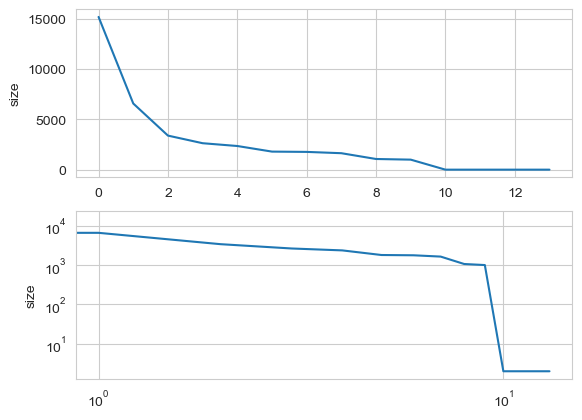

In [ ]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

In [ ]:
print(G.numberOfNodes())

37476


In [ ]:
for v in range(G.numberOfNodes()):
    if G.isIsolated(v):
        print(v)
        G.removeNode(v)

In [ ]:
print("Number of non isolated nodes: ",G.numberOfNodes())
nk.overview(G)

In [ ]:
communities = nk.community.detectCommunities(G)
nk.community.Modularity().getQuality(communities, G) #The value is in the range [-0.5,1] and usually depends both on the performance of the 
# algorithm and the presence of distinctive community structures in the network

In [ ]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

In [ ]:
print(communities)

To filter before loading the graph in gephi

In [ ]:
#A k-core decomposition of a graph is performed by successicely peeling away nodes with degree less than k. 
# The remaining nodes form the -core of the graph.
coreDec = nk.centrality.CoreDecomposition(G)
coreDec.run()

In [ ]:
for u in G.iterNodes():
    #print(w)
    if G.degree(u)>=10:
        G.removeNode(u)

In [ ]:
nk.overview(G)

In [ ]:
communities = nk.community.detectCommunities(G)
nk.community.Modularity().getQuality(communities, G) #The value is in the range [-0.5,1] and usually depends both on the performance of the 
# algorithm and the presence of distinctive community structures in the network

In [ ]:
nodes_score = [coreDec.scores(G,v) for v in G.nodes()]

In [ ]:
nk.overview(G)

In [ ]:
scc = nk.components.StronglyConnectedComponents(G)
scc.run()
print("number of components: ", scc.numberOfComponents())

In [ ]:
import os

if not os.path.isdir('./graphs'):
    os.makedirs('./graphs')
nk.writeGraph(G,"./graphs/graph_genre_GML_10.gml", nk.Format.GML)

In [ ]:
list_weights = []
list_edges = []
for u, v, w in G.iterEdgesWeights():
    if w > 60000:
        list_weights.append(w)
        list_edges.append([u,v])
#for i range G.degree(1)
print(len(list_edges))

In [ ]:
print(list_edges[1:10])

In [ ]:
print(len(list_edges))
for test_idx in range(len(list_edges[1:10])):
    #if(len(df_clean["characters"].iloc[indices[test_idx][0]]) >= 3 and 
    #   len(df_clean["characters"].iloc[indices[test_idx][1]]) >= 3 ):
    print()
    print(list_weights[test_idx])
    #print(list_edges[test_idx], list_weights[test_idx])
    print(df_clean["name"].iloc[list_edges[test_idx][0]], df_clean["release_date"].iloc[list_edges[test_idx][0]], df_clean["wikiID"].iloc[list_edges[test_idx][0]])
    print(df_clean["name"].iloc[list_edges[test_idx][1]], df_clean["release_date"].iloc[list_edges[test_idx][1]], df_clean["wikiID"].iloc[list_edges[test_idx][1]])

In [ ]:
test_idx = 5
print(df_clean["name"].iloc[list_edges[test_idx][0]], df_clean["release_date"].iloc[list_edges[test_idx][0]], df_clean["wikiID"].iloc[list_edges[test_idx][0]])
print(df_clean["plot"].iloc[list_edges[test_idx][0]])
print(df_clean["name"].iloc[list_edges[test_idx][1]], df_clean["release_date"].iloc[list_edges[test_idx][1]], df_clean["wikiID"].iloc[list_edges[test_idx][1]])
print(df_clean["plot"].iloc[list_edges[test_idx][1]])

In [ ]:
# Initalize and run PLM community detection algorithm
plm = nk.community.PLM(G)
plm.run()

# Visualize the karate graph with community detection
nk.vizbridges.widgetFromGraph(G, nodePartition = plm.getPartition())

In [ ]:
df_genre.head()

In [ ]:
attributes=df_genre
print(list_edges[1:10])

Communities analysis

In [14]:
G = nk.readGraph("graphs/graph_full_final.gml", nk.Format.GML)
nk.overview(G)
communities = nk.community.detectCommunities(G)
print('Communities Modularity', nk.community.Modularity().getQuality(communities, G)) 
# The value is in the range [-0.5,1] and usually depends both on the performance of the 
# algorithm and the presence of distinctive community structures in the network

print('Number of communities: ',communities.numberOfSubsets())
print('Communities sizes: ',communities.subsetSizes())
print('Number of nodes belonging to communities: ',communities.numberOfElements())


Network Properties:
nodes, edges			37476, 528026
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.000752
clustering coefficient		0.039616
min/max/avg degree		1, 32, 28.179421
degree assortativity		0.310737
number of connected components	3
size of largest component	37472 (99.99 %)
Communities detected in 0.08900 [s]
solution properties:
-------------------  ------------
# communities           10
min community size       2
max community size   15229
avg. community size   3747.6
imbalance                4.06323
edge cut             94136
edge cut (portion)       0.178279
modularity               0.564281
-------------------  ------------
Communities Modularity 0.5642808887829419
Number of communities:  10
Communities sizes:  [15229, 5613, 6419, 4425, 2963, 2819, 2, 2, 2, 2]
Number of nodes belonging to communities:  37476


In [ ]:
import plotly.express as px

df_communities=pd.DataFrame()
df_communities['size']=communities.subsetSizes()
df_communities['community_nb']=df_communities.index
df_communities.insert(0, 'community_nb', df_communities.pop('community_nb'))

fig = px.bar(df_communities, x='community_nb', y='size', color='size', height=400, text_auto='.2s',title='Title')
fig.show()

fig = px.pie(df_communities, values='size', names='community_nb', title='Title', color='size')
fig.update_traces(textposition='inside', textinfo='value')
fig.show()

In [ ]:
df_clean = pd.read_csv('df_clean.csv', encoding='utf-8')
df_clean = df_clean.iloc[: , 1:]
df_clean['community_nb']= np.nan
df_clean.head(4)

,wikiID,freeID,name,release_date,runtime,languages,countries,genres,plot,characters,actors,director,color,community_nb
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,long,{'English Language'},{'United States of America'},"{'Supernatural', 'Thriller', 'Science Fiction'...","Set in the second half of the 22nd century, th...","{'Benchley', 'Tres', 'Uno', 'Big Daddy Mars', ...","{'Liam Waite', 'Peter Jason', 'Rick Edelstein'...",John Carpenter,color,NaN
1,9363483,/m/0285_cd,White Of The Eye,1987.0,long,{'English Language'},{'United Kingdom'},"{'Erotic thriller', 'Thriller', 'Psychological...",A series of murders of rich young women throug...,set(),"{'David Keith', 'Cathy Moriarty'}",Cassian Elwes,color,NaN
2,261236,/m/01mrr1,A Woman in Flames,1983.0,long,{'German Language'},{'Germany'},{'Drama'},"Eva, an upper class housewife, becomes frustra...",set(),"{'Hanns Zischler', 'Mathieu Carrière', 'Gudrun...",Robert van Ackeren,color,NaN
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002.0,long,{'English Language'},{'South Africa'},"{'Fantasy', 'World cinema', 'Family Film', 'Ad...","Every hundred years, the evil Morgana returns...",{'Morgana'},"{'Greg Melvill-Smith', 'Sean Taylor', 'Kelly L...",NaN,NaN,NaN


In [ ]:
index_community=9
print(list(communities.getMembers(index_community)))

for i in range(communities.numberOfSubsets()):
    index=list(communities.getMembers(i))
    #print(i, max(index), min(index))
    df_clean.loc[index,'community_nb']=int(i)
df_clean.head(10)

[6065, 30169]


,wikiID,freeID,name,release_date,runtime,languages,countries,genres,plot,characters,actors,director,color,community_nb
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,long,{'English Language'},{'United States of America'},"{'Supernatural', 'Thriller', 'Science Fiction'...","Set in the second half of the 22nd century, th...","{'Benchley', 'Tres', 'Uno', 'Big Daddy Mars', ...","{'Liam Waite', 'Peter Jason', 'Rick Edelstein'...",John Carpenter,color,0.0
1,9363483,/m/0285_cd,White Of The Eye,1987.0,long,{'English Language'},{'United Kingdom'},"{'Erotic thriller', 'Thriller', 'Psychological...",A series of murders of rich young women throug...,set(),"{'David Keith', 'Cathy Moriarty'}",Cassian Elwes,color,1.0
2,261236,/m/01mrr1,A Woman in Flames,1983.0,long,{'German Language'},{'Germany'},{'Drama'},"Eva, an upper class housewife, becomes frustra...",set(),"{'Hanns Zischler', 'Mathieu Carrière', 'Gudrun...",Robert van Ackeren,color,1.0
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002.0,long,{'English Language'},{'South Africa'},"{'Fantasy', 'World cinema', 'Family Film', 'Ad...","Every hundred years, the evil Morgana returns...",{'Morgana'},"{'Greg Melvill-Smith', 'Sean Taylor', 'Kelly L...",NaN,NaN,2.0
4,6631279,/m/0gffwj,Little city,1997.0,long,{'English Language'},{'United States of America'},"{'Romance Film', 'Comedy-drama', 'Ensemble Fil...","Adam, a San Francisco-based artist who works a...","{'Rebecca', 'Nina'}","{'Jon Bon Jovi', 'Josh Charles', 'Penelope Ann...",Roberto Benabib,color,0.0
5,171005,/m/016ywb,Henry V,1989.0,long,{'English Language'},{'United Kingdom'},"{'Epic', 'War film', 'Period piece', 'Film ada...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,"{'Mistress Nell Quickly', 'Duke Thomas Beaufor...","{'Robert Stephens', 'Alec McCowen', 'Richard B...",Kenneth Branagh,color,0.0
6,18296435,/m/04cqrs4,Aaah Belinda,1986.0,NaN,{'Turkish Language'},{'Turkey'},{'Comedy'},"Serap, a young actress with a strong, lively p...",set(),{'Müjde Ar'},Atıf Yılmaz,NaN,1.0
7,11250635,/m/02r52hc,The Mechanical Monsters,NaN,NaN,{'English Language'},{'United States of America'},"{'Science Fiction', 'Animation', 'Fantasy', 'A...",The story starts as one of the robots flies i...,set(),"{'Joan Alexander', 'Bud Collyer'}",Dave Fleischer,NaN,3.0
8,77856,/m/0kcn7,Mary Poppins,1964.0,long,{'English Language'},{'United States of America'},"{'Musical', ""Children's/Family"", 'Fantasy', ""C...",The film opens with Mary Poppins perched in a...,"{'Admiral Boom', 'Mr. Dawes Senior', 'George B...","{'Dick Van Dyke', 'Matthew Garber', 'David Tom...",Robert Stevenson,color,0.0
9,21926710,/m/05p45cv,White on Rice,2009.0,long,set(),{'United States of America'},"{'Romance Film', 'Indie', 'Romantic comedy', '...",Jimmy ([[Hiroshi Watanabe loves dinosaurs and...,set(),"{'Justin Kwong', 'Jennifer Klekas', 'Hiroshi W...",Dave Boyle,color,0.0


In [ ]:
df_clean2=df_clean.copy()
df_clean2.insert(0, 'community_nb', df_clean2.pop('community_nb'))
df_clean2['genres'] = df_clean['genres'].apply(lambda x: x.replace("'","").replace("{","").replace("}","").split(", ")) 
df_clean2['genres'] = df_clean2['genres'].apply(lambda x: None if x==['set()'] else x)
df_clean2['languages'] = df_clean['languages'].apply(lambda x: x.replace("'","").replace("{","").replace("}","").split(", ")) 
df_clean2['languages'] = df_clean2['languages'].apply(lambda x: None if x==['set()'] else x)
df_clean2['countries'] = df_clean['countries'].apply(lambda x: x.replace("'","").replace("{","").replace("}","").split(", ")) 
df_clean2['countries'] = df_clean2['countries'].apply(lambda x: None if x==['set()'] else x)
df_clean2['characters'] = df_clean['characters'].apply(lambda x: x.replace("'","").replace("{","").replace("}","").split(", "))
df_clean2['characters'] = df_clean2['characters'].apply(lambda x: None if x==['set()'] else x)
df_clean2['actors'] = df_clean['actors'].apply(lambda x: x.replace("'","").replace("{","").replace("}","").split(", ")) 
df_clean2['actors'] = df_clean2['actors'].apply(lambda x: None if x==['set()'] else x)
df_clean2['decade'] = df_clean2.copy()['release_date'].apply(lambda x: x-x%10)
df_clean2.head()

,community_nb,wikiID,freeID,name,release_date,runtime,languages,countries,genres,plot,characters,actors,director,color,decade
0,0.0,975900,/m/03vyhn,Ghosts of Mars,2001.0,long,[English Language],[United States of America],"[Supernatural, Thriller, Science Fiction, Spac...","Set in the second half of the 22nd century, th...","[Benchley, Tres, Uno, Big Daddy Mars, Dos, Lie...","[Liam Waite, Peter Jason, Rick Edelstein, Ice ...",John Carpenter,color,2000.0
1,1.0,9363483,/m/0285_cd,White Of The Eye,1987.0,long,[English Language],[United Kingdom],"[Erotic thriller, Thriller, Psychological thri...",A series of murders of rich young women throug...,None,"[David Keith, Cathy Moriarty]",Cassian Elwes,color,1980.0
2,1.0,261236,/m/01mrr1,A Woman in Flames,1983.0,long,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",None,"[Hanns Zischler, Mathieu Carrière, Gudrun Land...",Robert van Ackeren,color,1980.0
3,2.0,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002.0,long,[English Language],[South Africa],"[Fantasy, World cinema, Family Film, Adventure]","Every hundred years, the evil Morgana returns...",[Morgana],"[Greg Melvill-Smith, Sean Taylor, Kelly LeBroc...",NaN,NaN,2000.0
4,0.0,6631279,/m/0gffwj,Little city,1997.0,long,[English Language],[United States of America],"[Romance Film, Comedy-drama, Ensemble Film, Dr...","Adam, a San Francisco-based artist who works a...","[Rebecca, Nina]","[Jon Bon Jovi, Josh Charles, Penelope Ann Mill...",Roberto Benabib,color,1990.0


In [ ]:
df_prob = pd.read_csv('./topics_probabilities_new_embedding.csv', header=None)    #load des probas d'appartenir a un topic pour grand embedding modèle, sans reduction topic, avec noms
df_topic = pd.read_csv('./topic_info.csv') 

In [ ]:
df_prob.columns= df_topic['Name'].values.tolist()[1:]
df_clean2 = df_clean2.join(df_prob)

In [ ]:
import plotly.express as px

dict_communities={}

for i in range(communities.numberOfSubsets()):
    df_comm_topic=pd.DataFrame()
    df_comm_topic['count']=df_clean2.loc[df_clean2['community_nb']==i].iloc[:, 15:].idxmax(axis=1).value_counts()
    df_comm_topic['first topic']=df_comm_topic.index
    df_comm_topic.reset_index(inplace=True, drop=True)

    df_comm_genre=pd.DataFrame()
    df_comm_genre['count']=pd.DataFrame(df_clean2.loc[df_clean2['community_nb']==i].explode('genres')['genres'].value_counts())
    df_comm_genre['genre']=df_comm_genre.index
    df_comm_genre.reset_index(inplace=True, drop=True)

    df_comm_countries=pd.DataFrame()
    df_comm_countries['count']=pd.DataFrame(df_clean2.loc[df_clean2['community_nb']==i].explode('countries')['countries'].value_counts())
    df_comm_countries['country']=df_comm_countries.index
    df_comm_countries.reset_index(inplace=True, drop=True)

    df_comm_languages=pd.DataFrame()
    df_comm_languages['count']=pd.DataFrame(df_clean2.loc[df_clean2['community_nb']==i].explode('languages')['languages'].value_counts())
    df_comm_languages['languages']=df_comm_languages.index
    df_comm_languages.reset_index(inplace=True, drop=True)

    df_comm_actors=pd.DataFrame()
    df_comm_actors['count']=pd.DataFrame(df_clean2.loc[df_clean2['community_nb']==i].explode('actors')['actors'].value_counts())
    df_comm_actors['actor']=df_comm_actors.index
    df_comm_actors.reset_index(inplace=True, drop=True)

    df_comm_characters=pd.DataFrame()
    df_comm_characters['count']=pd.DataFrame(df_clean2.loc[df_clean2['community_nb']==i].explode('characters')['characters'].value_counts())
    df_comm_characters['character']=df_comm_characters.index
    df_comm_characters.reset_index(inplace=True, drop=True)

    df_comm_director=pd.DataFrame()
    df_comm_director['count']=pd.DataFrame(df_clean2.loc[df_clean2['community_nb']==i]['director'].value_counts())
    df_comm_director['director']=df_comm_director.index
    df_comm_director.reset_index(inplace=True, drop=True)

    df_comm_runtime=pd.DataFrame()
    df_comm_runtime['count']=pd.DataFrame(df_clean2.loc[df_clean2['community_nb']==i]['runtime'].value_counts())
    df_comm_runtime['runtime']=df_comm_runtime.index
    df_comm_runtime.reset_index(inplace=True, drop=True)

    df_comm_color=pd.DataFrame()
    df_comm_color['count']=pd.DataFrame(df_clean2.loc[df_clean2['community_nb']==i]['color'].value_counts())
    df_comm_color['color']=df_comm_color.index
    df_comm_color.reset_index(inplace=True, drop=True)

    df_comm_decade=pd.DataFrame()
    df_comm_decade['count']=pd.DataFrame(df_clean2.loc[df_clean2['community_nb']==i].explode('decade')['decade'].value_counts())
    df_comm_decade['decade']=df_comm_decade.index
    df_comm_decade.reset_index(inplace=True, drop=True)

    dict_communities[i]={"first topic":df_comm_topic, "genre":df_comm_genre, "countries":df_comm_countries,"languages":df_comm_languages,
                    "actors":  df_comm_actors, "characters":df_comm_characters, "director": df_comm_director, "runtime":df_comm_runtime, 
                    "color":df_comm_color, "decade":df_comm_decade}


0
1
2
3
4
5
6
7
8
9
10
11
12


In [ ]:
index_community=1

fig = px.bar(dict_communities[index_community]['first topic'][:10], x='first topic', y='count', title="Title")
fig.show()

fig = px.bar(dict_communities[index_community]['genre'][:10], x='genre', y='count', title="Title")
fig.show()

fig = px.bar(dict_communities[index_community]['countries'][:10], x='country', y='count', title="Title")
fig.show()

fig = px.bar(dict_communities[index_community]['languages'][:10], x='languages', y='count', title="Title")
fig.show()

fig = px.bar(dict_communities[index_community]['actors'][:10], x='actor', y='count', title="Title")
fig.show()

fig = px.bar(dict_communities[index_community]['characters'][:10], x='character', y='count', title="Title")
fig.show()

fig = px.bar(dict_communities[index_community]['director'][:10], x='director', y='count', title="Title")
fig.show()

fig = px.bar(dict_communities[index_community]['runtime'][:10], x='runtime', y='count', title="Title")
fig.show()

fig = px.bar(dict_communities[index_community]['color'][:2], x='color', y='count', title="Title")
fig.show()

fig = px.bar(dict_communities[index_community]['decade'][:10], x='decade', y='count', title="Title")
fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig=make_subplots(rows=2, cols=5)

# Ajouter le premier graphique à la première ligne et la première colonne
fig1 = px.bar(dict_communities[index_community]['first topic'][:10], x='first topic', y='count', title="Title")
data1 = fig1.data[0]
layout1 = fig1.layout
bar1 = go.Bar(data1)
fig.add_trace(bar1, row=1, col=1)

# Ajouter le deuxième graphique à la première ligne et la deuxième colonne
fig1 = px.bar(dict_communities[index_community]['genre'][:10], x='genre', y='count', title="Title")
data1 = fig1.data[0]
layout1 = fig1.layout
bar1 = go.Bar(data1)
fig.add_trace(bar1, row=1, col=2)


# Ajouter le troisième graphique à la première ligne et la troisième colonne
fig1= px.bar(dict_communities[index_community]['countries'][:10], x='country', y='count', title="Title")
data1 = fig1.data[0]
layout1 = fig1.layout
bar1 = go.Bar(data1)
fig.add_trace(bar1, row=1, col=3)

# Ajouter le quatrième graphique à la première ligne et la quatrième colonne
fig1 = px.bar(dict_communities[index_community]['languages'][:10], x='languages', y='count', title="Title")
data1 = fig1.data[0]
layout1 = fig1.layout
bar1 = go.Bar(data1)
fig.add_trace(bar1, row=1, col=4)

# Ajouter le cinquième graphique à la deuxième ligne et la première colonne
fig1 = px.bar(dict_communities[index_community]['actors'][:10], x='actor', y='count', title="Title")
data1 = fig1.data[0]
layout1 = fig1.layout
bar1 = go.Bar(data1)
fig.add_trace(bar1, row=1, col=5)

# Ajouter le sixième graphique à la deuxième ligne et la deuxième colonne
fig1 = px.bar(dict_communities[index_community]['characters'][:10], x='character', y='count', title="Title")
data1 = fig1.data[0]
layout1 = fig1.layout
bar1 = go.Bar(data1)
fig.add_trace(bar1, row=2, col=1)

# Ajouter le sixième graphique à la deuxième ligne et la deuxième colonne
fig1 = px.bar(dict_communities[index_community]['director'][:10], x='director', y='count', title="Title")
data1 = fig1.data[0]
layout1 = fig1.layout
bar1 = go.Bar(data1)
fig.add_trace(bar1, row=2, col=2)

# Ajouter le septième graphique à la deuxième ligne et la troisième colonne
fig1 = px.bar(dict_communities[index_community]['runtime'][:10], x='runtime', y='count', title="Title")
data1 = fig1.data[0]
layout1 = fig1.layout
bar1 = go.Bar(data1)
fig.add_trace(bar1, row=2, col=3)

# Ajouter le huitième graphique à la deuxième ligne et la quatrième colonne
fig1 = px.bar(dict_communities[index_community]['color'][:2], x='color', y='count', title="Title")
data1 = fig1.data[0]
layout1 = fig1.layout
bar1 = go.Bar(data1)
fig.add_trace(bar1,  row=2, col=4)

# Ajouter le huitième graphique à la deuxième ligne et la quatrième colonne
fig1 = px.bar(dict_communities[index_community]['decade'][:10], x='decade', y='count', title="Title")
data1 = fig1.data[0]
layout1 = fig1.layout
bar1 = go.Bar(data1)
fig.add_trace(bar1,  row=2, col=5)

fig.update_layout(height=700, width=1100, title_text="Multiple Subplots with Titles")

fig.show()

In [ ]:
#df_comm_genre2=df_comm_genre.copy()
#df_comm_genre2.loc[ df_comm_genre2['count']*100/sum(df_comm_genre2['count']) < 1, 'genre'] = 'Other genres' # Represent only large countries
fig = px.pie(dict_communities[index_community]['genre'], values='count', names='genre', title='Title')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [ ]:
import plotly.express as px

feature='genre'

# Create the plots
fig1 = px.bar(dict_communities[0][feature][:10], x=feature, y='count', title="Plot 0")
fig2 = px.bar(dict_communities[1][feature][:10], x=feature, y='count', title="Plot 1")
fig3 = px.bar(dict_communities[2][feature][:10], x=feature, y='count', title="Plot 2")
fig4 = px.bar(dict_communities[3][feature][:10], x=feature, y='count', title="Plot 3")
fig5 = px.bar(dict_communities[4][feature][:10], x=feature, y='count', title="Plot 4")
fig6 = px.bar(dict_communities[5][feature][:10], x=feature, y='count', title="Plot 5")
fig7 = px.bar(dict_communities[6][feature][:10], x=feature, y='count', title="Plot 6")
fig8 = px.bar(dict_communities[7][feature][:10], x=feature, y='count', title="Plot 7")
fig9 = px.bar(dict_communities[8][feature][:10], x=feature, y='count', title="Plot 8")

# Extract the data and layout from the plotly.express figures
data1 = fig1.data[0]
layout1 = fig1.layout
data2 = fig2.data[0]
layout2 = fig2.layout
data3 = fig3.data[0]
layout3 = fig3.layout
data4 = fig4.data[0]
layout4 = fig4.layout
data5 = fig5.data[0]
layout5 = fig5.layout
data6 = fig6.data[0]
layout6 = fig6.layout
data7 = fig7.data[0]
layout7 = fig7.layout
data8 = fig8.data[0]
layout8 = fig8.layout
data9 = fig9.data[0]
layout9 = fig9.layout

# Create a dropdown menu for switching between plots
updatemenus = [
    {
        "buttons":
        [
            {
                "args": [{"visible": [True, False, False, False, False, False, False, False, False]},
                         {"title": feature, "annotations": []}],
                "label": "Community 0",
                "method": "update"
            },
            {
                "args": [{"visible": [False, True, False, False, False, False, False, False, False]},
                         {"title": feature, "annotations": []}],
                "label": "Community 1",
                "method": "update"
            },
            {
                "args": [{"visible": [False, False, True, False, False, False, False, False, False]},
                         {"title": feature, "annotations": []}],
                "label": "Community 2",
                "method": "update"
            },
            {
                "args": [{"visible": [False, False, False, True, False, False, False, False, False]},
                         {"title": feature, "annotations": []}],
                "label": "Community 3",
                "method": "update"
            },
            {
                "args": [{"visible": [False, False, False, False, True, False, False, False, False]},
                         {"title": feature, "annotations": []}],
                "label": "Community 4",
                "method": "update"
            },
            {
                "args": [{"visible": [False, False, False, False, False, True, False, False, False]},
                         {"title": feature, "annotations": []}],
                "label": "Community 5",
                "method": "update"
            },
            {
                "args": [{"visible": [False, False, False, False, False, False, True, False, False]},
                         {"title": feature, "annotations": []}],
                "label": "Community 6",
                "method": "update"
            },
            {
                "args": [{"visible": [False, False, False, False, False, False, False, True, False]},
                         {"title": feature, "annotations": []}],
                "label": "Community 7",
                "method": "update"
            },
            {
                "args": [{"visible": [False, False, False, False, False, False, False, False, True]},
                         {"title": feature, "annotations": []}],
                "label": "Community 8",
                "method": "update"
            },
        ],
        "direction": "down",
        "showactive": True,
        "type": "buttons", #"topdown"
        "x": 1.05,
        "xanchor": "left",
        "y": 1.1,
        "yanchor": "top"
    }
]   


# Add the dropdown menu to the layout
layout = go.Layout(updatemenus=updatemenus)

# Create the bar traces
bar1 = go.Bar(data1, visible=True)
bar2 = go.Bar(data2, visible=False)
bar3 = go.Bar(data3, visible=False)
bar4 = go.Bar(data4, visible=False)
bar5 = go.Bar(data5, visible=False)
bar6 = go.Bar(data6, visible=False)
bar7 = go.Bar(data7, visible=False)
bar8 = go.Bar(data8, visible=False)
bar9 = go.Bar(data9, visible=False)

# Combine the traces into a single figure
fig = go.Figure(data=[bar1, bar2, bar3, bar4, bar5, bar6, bar7, bar8, bar9], layout=layout)

# Display the figure
fig.show()

### 4. Tuning the weights using sequels

How to tell if our similarity function between two movies is working well, and if our weights are well tuned? First of all, we can't say it for sure, since it is a subjective question. However usually we can still agree that movies that are part of a sequel should have a high similarity function between them. Instead of looking just at the resulting value, we can check what is the similarity across all features.

**Finding sequels**

Unfortunately, we don't have the data directly accessible of the sequels. The data in `character.metadata.tsv` has characters that repeat across different movies, however we realized that once we cleaned our dataset (in out dataframe `df_clean`), we couldn't match most of the characters to our movies. We also realized that a lot of characters were not documented in `character.metadata.tsv`, so we decided to build the sequels on our own. To do this, we assume that the following hypothesis:

If two movies have similar characters, similar actors and similar headlines, they are probably part of a sequel.

Fortunately, we already have the similarity matrices, so we can access this data easily:

In [ ]:
#take movies with character similarity above 21000, equivalent to 0.32 if normalized to 1
loaded_sim = np.fromfile("../similarities/jacc_characters", dtype = 'uint16')
loaded_sim = loaded_sim.reshape(37476, 37476)
upper_sim = np.triu(loaded_sim, 1)
edges_chars = upper_sim>=21000

#take movies with actors similarity above 21000, equivalent to 0.32 if normalized to 1
loaded_sim = np.fromfile("../similarities/jacc_actors", dtype = 'uint16')
loaded_sim = loaded_sim.reshape(37476, 37476)
upper_sim = np.triu(loaded_sim, 1)
edges_actors = upper_sim>=21000

#take movies with headline similarity above 21000, equivalent to 0.32 if normalized to 1
loaded_sim = np.fromfile("../similarities/cosine_headlines", dtype = 'uint16')
loaded_sim = loaded_sim.reshape(37476, 37476)
upper_sim = np.triu(loaded_sim, 1)
edges_headlines = upper_sim>=21000

#all conditions together
sequel_edges = np.multiply(np.multiply(edges_chars, edges_actors), edges_headlines)
indices = np.transpose(np.nonzero(sequel_edges))
print("We find ",len(indices), "pairs of movies from same sequels.")

We add one more filter to this, which is to only keep movies where there at least two characters. This is to avoid finding pairs by chance, because they have only one character with a common name like "John".

In [ ]:
filtered_indices = []
i = 0
print(len(indices))
for edge in indices:
    if(len(df_clean["characters"].iloc[edge[0]]) >= 2 and 
       len(df_clean["characters"].iloc[edge[1]]) >= 2 ):
        filtered_indices.append(edge)
        #we can print the pairs to check they are real sequels
        #print(df_clean["name"].iloc[edge[0]])
        #print(df_clean["name"].iloc[edge[1]])
        i += 1
print("We now have ", i, "pairs.")

Now we can compute the average of the similarity of each feature:

In [ ]:
list_similarities = ["jacc_genre", "cosine_plots", "cosine_headlines", 
                     "integ_date", "jacc_actors", "jacc_characters", "jacc_language",
                    "jacc_country", "bin_color", "bin_director", "bin_runtime"]

similarity_scores = np.zeros(len(list_similarities))

In [ ]:
for i in range(len(list_similarities)):
    if(i <= 7):
        a = np.fromfile("../similarities/" + list_similarities[i], dtype = 'uint16')
    else:
        a = np.fromfile("../similarities/" + list_similarities[i], dtype = 'uint8')
    a = a.reshape(37476, 37476)
    for sequel_pair in filtered_indices:
        if(i <= 7):
            similarity_scores[i] += (a[sequel_pair[0]][sequel_pair[1]]/65535.0)
        else:
            similarity_scores[i] += a[sequel_pair[0]][sequel_pair[1]]
    print(list_similarities[i], ": ", similarity_scores[i] / len(filtered_indices))

We find that some score are higher than we expected (like the plots) while other are smaller (like the directors).
When investigating in each pair individually, we discoverey that the `directors` and `color` were quite low because they often had a `NaN` value. Also in the pairs there are a lot of movies from the Loonay Tunes, and they often have only part of the characters that repeat, which is also skewing the average `character` similarity down.

**Conclusion**

Even with the points discussed above, they scores are quite good on average (from 0.5 to 0.8 for most features), which validates our metrics. It also accentuates the problem with our incomplete scrapped data, but overall we are satisfied with the results.

---
## Visualization of the graph: Gephi

To visualize our graph we use Gephi. Gephi is an "open-source platform for visualizing and manipulating large graphs". Their Graph Layout Algorithm is force based, meaning nodes will repell and attract each other in function of the distance between them, and the visualization is in the equilibrium state.

To open a graph in Gephi, we need to export it in the `.gml` format. We do this with:

In [76]:
nk.writeGraph(G,"graph_full_final.gml", nk.Format.GML)

We also want to be able to visualize the clusters and to be able to show the graph by decade to see its evolution. For this we need to create attributes for the nodes, and export these attributes as `.csv` files.

In [ ]:
att_cluster = np.zeros(G.numberOfNodes())
att_decade = np.zeros(G.numberOfNodes())

for i in range(communities.numberOfSubsets()):
    index = list(communities.getMembers(i))
    for j in index:
        att_cluster[j] = int(i)

for i in range(G.numberOfNodes()):
    att_decade[i] = df_clean["decades"][i]

np.savetxt('cluster_attribute.csv', att_cluster, fmt='%i', delimiter=',')    
np.savetxt('decade_attribute.csv', att_decade, fmt='%i', delimiter=',')

We then modify these files in excel to give a name to the attribute, and create a column `Id` with numbers 0 - `G.numberOfNodes()-1` so Gephi can recognize that it is a descrition for the nodes.

When loading our graph, and color the nodes respectively to its cluster, we get the following graph:
<div>
<img src="images/Tuned.png" width="600"/>
</div>


We can also plot only part of the graph, by selecting that we only plot the nodes for which the attribute decade is equal 1950 (for example). Thus we can get the following plots:

1920 | 1970 | 2000
- | - | -
![alt](images/1920.png) | ![alt](images/1970.png) | ![alt](images/2000.png)

We don't plot it cumulatively, meaning that we only plot the movies in one given decade. Still we see that there are more and more movies each decade, which isn't very surprizing.

---

## Annexe: Mathematical definitions related to similarity

#### 1.1 Cosine similarity
$$
cosine \: similarity(A,B)=S_c(A,B)=cos(\theta)=\frac{A \cdot B}{\|A\| \|B\|}=\frac{\sum_{i=1}^{n}A_iB_i}{\sqrt{\sum_{i=1}^{n} A_i^2}\sqrt{\sum_{i=1}^{n} B_i^2}}
$$
Where $A,B \in \mathbb{R}^n$, $S_c(A,B) \in [-1,1]$ where -1 means that the two vectors are exactly opposite, and 1 means that they are exactly similar and 0 means that they are orthognonal which shows decorrelation.

#### 1.2 Centered Cosine similarity
$$
centered \: cosine \: similarity(A,B)=\frac{(A-\overline{A}) \cdot (B-\overline{B})}{\|A-\overline{A}\| \|B-\overline{B}\|}
$$
Where A and B have been normalized before by substracting their mean.

#### 1.3 Soft cosine similarity
$$
soft \: cosine \: similarity(A,B)=\frac{\sum_{i,j}^{n}s_{ij}A_iB_j}{\sqrt{\sum_{i,j}^{n} s_{ij}A_iA_j}\sqrt{\sum_{i,j}^{n} s_{ij}B_iB_j}}
$$
where $s_{ij}$=similarity($feature_i$,$feature_j$). For example if $s_{ii}$=1 and $s_{ij}$=0 $\forall i\neq j$ then there is no similarity between features, then the soft cosine similarity is equal to the cosine similarity. In the case where features are words, the matrix $S$ has to define the similarity between words.

#### 1.4 Associated distance with cosine similarity
- **Angular distance**

if $A_i,B_i \in \mathbb{R}$ 
$$
angular \: distance=D_\theta=\frac{arccos(S_c(A,B))}{\pi}=\frac{\theta}{\pi}
$$
$$
angular \: similarity=S_\theta=1-D_\theta=1-\frac{\theta}{\pi}
$$
if $A_i,B_i \in \mathbb{R}$ and $A_i,B_i\geq 0$
$$
angular \: distance=D_\theta=\frac{2 \cdot \textrm{arccos}(S_c(A,B))}{\pi}=\frac{2\theta}{\pi}
$$
$$
angular \: similarity=S_\theta=1-D_\theta=1-\frac{2\theta}{\pi}
$$
Where the angular distacne is a formal distance metric, however the arccos computation cost makes it more computationally expensive and slower.

- **Cosine distance**

$$
cosine \: distance=D_c=1-S_c(A,B)
$$
Where the cosine distance is an unformal distance metric (it does not respect the triangle inequality or Schwarz inequality) but it is less computationally expensive.


- **L2-normalized Euclidean distance**

From the L2 distance defined as followed: $ \|x\|_2=\sqrt{\sum x_i^2}=\sqrt{x.x} $ and the euclidean distance defined as followed: 
$ d(A,B)=|A-B|=\sqrt{\sum _{i=1}^{n} (A_i-B_i)^2 } $, we get the L2-normalized Euclidean distance:
$$
L2-normalized \: Euclidean \: distance=\sqrt{\sum _{i=1}^{n} (A_i'-B_i')^2} \quad \textrm{where} \quad A'=\frac{A}{\|A\|_2}
$$

The cosine similarity and associated distances reflects relative rather than absolute comparison of vectors. For example vectors $A$ and $\alpha A$ where $\alpha \in \mathbb{R}$ are maximally similar. Therefore this similarity is appropriate for data where frequency is more important than absolute value. For text comparison it can be very useful, we could compare the frequency of terms in a document.  

#### 1.5 Jaccard similarity coefficient

$$
J(A,B) = \frac{|A \cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}
$$
where $J(A,B) \in [0,1]$.
It measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets.  

#### 1.6 Associated distance with Jaccard similarity
$$
d_J(A,B)=1-J(A,B)=\frac{|A\cup B|-|A\cap B|}{|A\cup B|}
$$
The Jaccard distance, which measures dissimilarity between sample sets, is complementary to the Jaccard coefficient and is obtained by subtracting the Jaccard coefficient from 1, or, equivalently, by dividing the difference of the sizes of the union and the intersection of two sets by the size of the union.